---
We'll use tensorflow to predict the number of shapes in an image.  But first: greyscale images.

---

In [6]:
import os
from PIL import Image


input_directory = 'rotated-images'
output_directory = 'greyscale-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  greyscale_image = image.convert('L')
  output_path = os.path.join(output_directory, filename)
  greyscale_image.save(output_path)

---
let's examine a few..

---

1-red-striped-oval-45.png


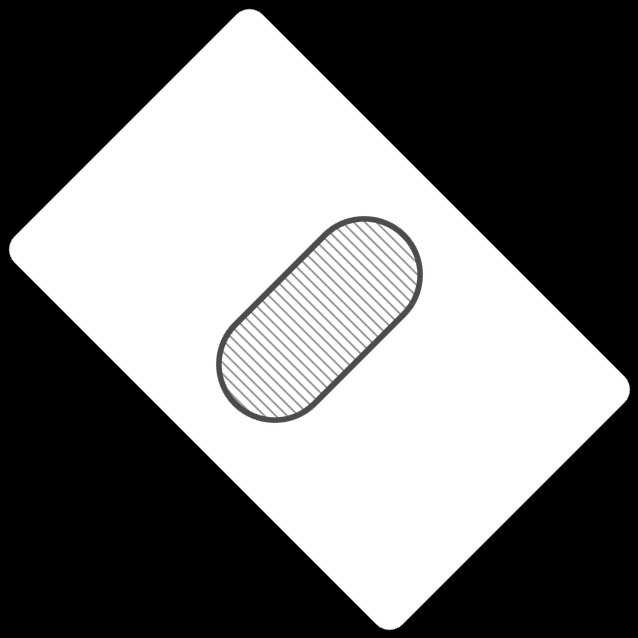

3-purple-solid-bean-135.png


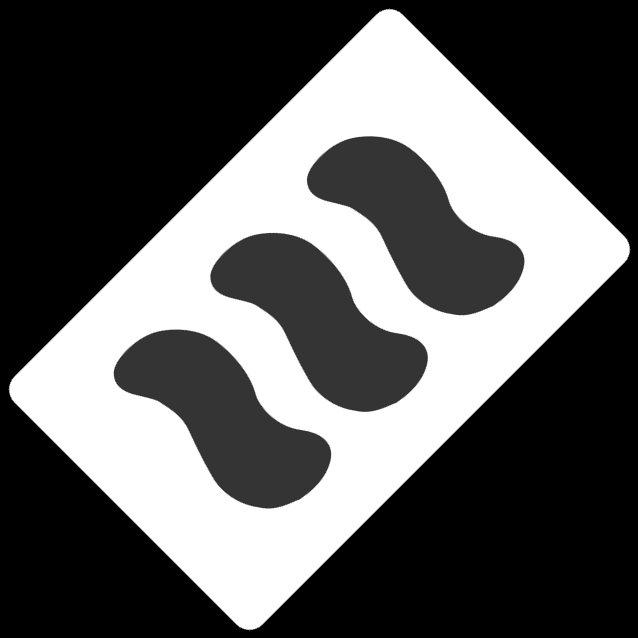

2-green-empty-diamond-270.png


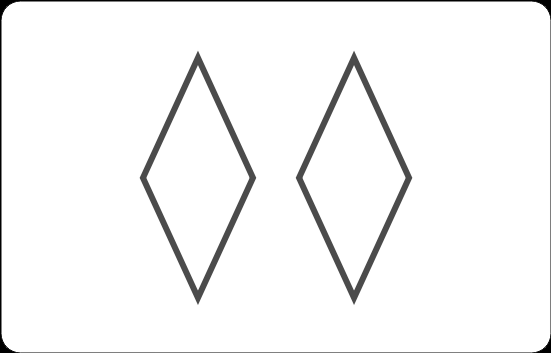

In [7]:
from IPython import display


images = (
  '1-red-striped-oval-45.png',
  '3-purple-solid-bean-135.png',
  '2-green-empty-diamond-270.png',
)

for filename in images:
  path = os.path.join(output_directory, filename)
  print filename
  display.display(display.Image(filename=path))

---
get the pixel data, save as `.npy` files in `greyscale-data`

---

In [ ]:
import numpy as np
import png


input_directory = 'greyscale-images'
output_directory = 'greyscale-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  path = os.path.join(input_directory, filename)
  with open(path, 'rb') as image_file:
    reader = png.Reader(file=image_file)
    _, _, pixels, _ = reader.asDirect()
  data = np.array([x / 255. for row in pixels for x in row])
  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, data)

---
setup tensorflow

---

In [14]:
import tensorflow as tf


width = 352
height = 550

x = tf.placeholder(tf.float32, shape=[None, width*height])
W = tf.Variable(tf.zeros([width*height, 3]))
b = tf.Variable(tf.zeros([3]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 3])

cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.000001).minimize(cross_entropy)

session = tf.Session()
session.run(tf.initialize_all_variables())

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

kinds = [
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
]

all_xs = []
for filename in os.listdir(output_directory):
  path = os.path.join(input_directory, filename)
  all_xs = numpy.load(path)
  

all_xs = [image for image, kind in images]
all_ys = [kinds[kind] for image, kind in images]

for i in range(10000):
    print 'iteration:', i
    batch = random.sample(images, 100)
    batch_xs = [image for image, kind in batch]
    batch_ys = [kinds[kind] for image, kind in batch]
    # for a in batch_ys:
    #   print argmax(a),
    # print
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if (i % 16) == 15:
        print 'accuracy:', sess.run(accuracy, feed_dict={x: all_xs, y_: all_ys})

print 'done'